In [68]:
#General############################################
import pandas as pd
import numpy as np
import re
import pprint
from time import sleep
from allfunctions import *
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import table

#WebScraping########################################
from bs4 import BeautifulSoup
import requests

#Spotify############################################
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from Credentials import Client_ID, Client_Secret
import json

#Machine Learning###################################
from sklearn import datasets 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pickle


------------------------------------------

# Objective Day 1


Create a function to scrape the Billboards 100 HOT songs and create local dataframe of songs with them including:

* Song’s name

* Song’s artist

# Objective Day 2

Create a second function to retrieve the audio features of a given song.

Create a third function to update the internal database with the song features using the previous function and to add this information to the dataframe 


* Song’s url/ uri

* Song’s audio_features


Recommendation: create a function to extend the internal database with songs of your choice/playlist,.... The more songs you have in the database, the better. (you will see tomorrow why).


# Objective Day 3

* Fit the standard scaler to scale the audio features of each song using both dataframes.

* Save the freshly trained standard scaler with pickle

* Get the user’s song audio features

* Apply the trained scaler to transform the user’s song audio features

Create a function to fit  the K-Means clustering method using all the songs contained in the both datasets ( hot100 and spotify ).

Remember to:
- Do some research on the optimal K-value for the K-means
- Save the final K-means model with pickle
- Use the trained K-means model to predict the cluster of each song in the internal databases and add this information to the internal databases



# Objective Day 4

Create a function to ask the user:

- Song title
- Song artist

Create a function to search the user song in the Spotify API to get the audio features

Create a function to retrieve the standard scaler previously saved and to scale the song’s audio features

Create a function to retrieve the K-Means model and predicts to which cluster belongs the song.

Create a function to retrieve one/more songs at random from the corresponding database which belongs to the same cluster as the user’s song and it’s not the same as the user song.


------------------------------------------

# Webscraping Hot 100

In [3]:
#Link to Hot 100 Chart
url = "https://www.billboard.com/charts/hot-100"

#Setting up Spotify API
client_credentials_manager = SpotifyClientCredentials(client_id=Client_ID, client_secret=Client_Secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [4]:
#Importing url info
response = requests.get(url)

In [5]:
#Getting the html code for the website.
soup = BeautifulSoup(response.text, "html.parser")

In [6]:
#List of song titles from the Hot 100 chart
top_100_song_titles = [tag.select("span.chart-element__information__song.text--truncate.color--primary")[0].get_text() for tag in soup.select("span.chart-element__information")]

In [7]:
#List of song artists from the Hot 100 chart
top_100_song_artists = [elem.select("span.chart-element__information__artist.text--truncate.color--secondary")[0].get_text() for elem in soup.select("span.chart-element__information")]

In [8]:
#Creating a dictionary with all the information
top_100_artists_titles_dict = {"artist_Names":top_100_song_artists, "song_Names":top_100_song_titles} 

In [9]:
#Converting the dictionary to a dataframe
top_100_artists_titles_df = create_dataframe_from_dictionary(top_100_artists_titles_dict)

## Audio features from one song

In [10]:
#Getting json file with all information about song.
song = get_all_information_about_song("Butter")

Now we get the audiofeatures of our chosen song.

In [11]:
audio_features = sp.audio_features(song["tracks"]["items"][0]["uri"])[0]
#audio_features     #The audio-features of the song are shown as a dictionary.

In [12]:
audio_features_new = { key: [audio_features[key]] for key in list(audio_features.keys()) }

In [13]:
#Dataframe with the audio features for our chosen song.
pd.DataFrame(audio_features_new) 

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.759,0.459,8,-5.187,1,0.0948,0.00323,0,0.0906,0.695,109.997,audio_features,2bgTY4UwhfBYhGT4HUYStN,spotify:track:2bgTY4UwhfBYhGT4HUYStN,https://api.spotify.com/v1/tracks/2bgTY4UwhfBY...,https://api.spotify.com/v1/audio-analysis/2bgT...,164442,4


--------------------------------

## Code

### Top 100 Songs

Getting all the song names from our Hot Songs 100 and making a dataframe with uri. 

In [14]:
#Uri's of top 100 in a list.
top_100_uris = []
for i in top_100_song_titles:
    top_100_uris.append(get_uri_of_song(i))

In [15]:
#List with song uri's converted to list  of dicts of the audiofeatures.
top_100_audio_features = get_audio_features_from_list_of_uris(top_100_uris)

In [16]:
#Creating a dictionary with all the audio features and an empty list, which will be filled with the values from all songs.
top_100_dict_audio_features = create_dict_with_audiofeatures_for_all_songs(top_100_audio_features)
df_top_100 = pd.DataFrame(top_100_dict_audio_features)

### Random playlists

Getting the information from a random playlist.

In [17]:
#This playlist has around 5000 songs.
playlist_id = "4ehqP8QHaIPdHMsssoB4y2" 

#This creates a json list with all the songs info in the playlist.
playlist =  get_playlist_tracks("spotify", playlist_id) 

In [18]:
#The path to the uri for each song. 
#playlist[0]["track"]["uri"] 
get_uri_of_song(playlist[0])

'spotify:track:3oLG4x8uR2dEfBTR7YIPCK'

In [19]:
# This part creates three lists, one with the uri's the other with the artists names. The last one is a list of song titles

playlist_uri = [] #Creating a list with all the uris to get the other information.
playlist_artist_names = [] #Creating a list with all the artist names.
playlist_song_names = []

for i in range(len(playlist)):
    playlist_uri.append(playlist[i]["track"]["uri"]) #The i is the name of the song in the playlist.
    playlist_artist_names.append(playlist[i]["track"]["artists"][0]["name"])
    playlist_song_names.append(playlist[i]["track"]["name"])

In [20]:
playlist_audio_features = get_audio_features_from_list_of_uris(playlist_uri)

In [21]:
#Creating a list for each key in the audiofeatures. All keys 
playlist_dict_audiofeature = create_dict_with_audiofeatures_for_all_songs(playlist_audio_features)

In [22]:
#Dataframe column with playlist audio features.
df_playlist = pd.DataFrame(playlist_dict_audiofeature)

In [23]:
#Adding the artist names and song artists to dataframe.
df_artist_names = pd.DataFrame(playlist_artist_names, columns=["Artist_Names"])

In [25]:
#Dataframe column with song names.
df_song_names = pd.DataFrame(playlist_song_names, columns=["Song_Names"])

In [26]:
x = pd.concat([df_song_names, df_artist_names], axis=1)

In [37]:
pd.concat([x, df_playlist], axis=1)

,Song_Names,Artist_Names,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,Friday (feat. Mufasa & Hypeman) - Dopamine Re-...,Riton,0.824,0.862,2,-3.424,1,0.1260,0.00760,0.000132,0.3030,0.8010,122.980,audio_features,4cG7HUWYHBV6R6tHn1gxrl,spotify:track:4cG7HUWYHBV6R6tHn1gxrl,https://api.spotify.com/v1/tracks/4cG7HUWYHBV6...,https://api.spotify.com/v1/audio-analysis/4cG7...,169153,4
1,Twerkulator,City Girls,0.894,0.459,1,-5.986,1,0.0705,0.00103,0.000541,0.1480,0.0634,126.999,audio_features,5LcXPm8VdxN00Y1mKVXFLV,spotify:track:5LcXPm8VdxN00Y1mKVXFLV,https://api.spotify.com/v1/tracks/5LcXPm8VdxN0...,https://api.spotify.com/v1/audio-analysis/5LcX...,138542,4
2,Levitating (feat. DaBaby),Dua Lipa,0.702,0.825,6,-3.787,0,0.0601,0.00883,0.000000,0.0674,0.9150,102.977,audio_features,463CkQjx2Zk1yXoBuierM9,spotify:track:463CkQjx2Zk1yXoBuierM9,https://api.spotify.com/v1/tracks/463CkQjx2Zk1...,https://api.spotify.com/v1/audio-analysis/463C...,203064,4
3,Leave The Door Open,Bruno Mars,0.586,0.616,5,-7.964,1,0.0324,0.18200,0.000000,0.0927,0.7190,148.088,audio_features,7MAibcTli4IisCtbHKrGMh,spotify:track:7MAibcTli4IisCtbHKrGMh,https://api.spotify.com/v1/tracks/7MAibcTli4Ii...,https://api.spotify.com/v1/audio-analysis/7MAi...,242096,4
4,Beautiful Mistakes (feat. Megan Thee Stallion),Maroon 5,0.713,0.676,10,-5.483,1,0.0270,0.03770,0.000000,0.1540,0.7210,99.048,audio_features,6fRxMU4LWwyaSSowV441IU,spotify:track:6fRxMU4LWwyaSSowV441IU,https://api.spotify.com/v1/tracks/6fRxMU4LWwya...,https://api.spotify.com/v1/audio-analysis/6fRx...,227395,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,Devotion - NOW What's Next!,Tone Stith,0.587,0.840,1,-3.417,1,0.0383,0.02700,0.000000,0.6440,0.5560,105.025,audio_features,3KbTdgJrRWCQ2XPkNS0Jtr,spotify:track:3KbTdgJrRWCQ2XPkNS0Jtr,https://api.spotify.com/v1/tracks/3KbTdgJrRWCQ...,https://api.spotify.com/v1/audio-analysis/3KbT...,246760,4
252,Josh - NOW What's Next!,Peach PRC,0.691,0.451,3,-6.163,1,0.0593,0.21500,0.000000,0.2170,0.6400,105.053,audio_features,5Rb8vGlCczlfV0IFxIU69r,spotify:track:5Rb8vGlCczlfV0IFxIU69r,https://api.spotify.com/v1/tracks/5Rb8vGlCczlf...,https://api.spotify.com/v1/audio-analysis/5Rb8...,159000,4
253,Burning Fire - NOW What's Next!,Camino,0.753,0.753,1,-5.810,1,0.0396,0.01810,0.000012,0.2640,0.6440,103.007,audio_features,3RW3f1pllZD90XlFlm7jxk,spotify:track:3RW3f1pllZD90XlFlm7jxk,https://api.spotify.com/v1/tracks/3RW3f1pllZD9...,https://api.spotify.com/v1/audio-analysis/3RW3...,228013,4
254,Slow Heart - NOW What's Next!,TWIN XL,0.580,0.885,9,-4.372,0,0.1020,0.00412,0.000058,0.5590,0.8190,140.029,audio_features,4UdJwMfXO7r3eEeiidsLwe,spotify:track:4UdJwMfXO7r3eEeiidsLwe,https://api.spotify.com/v1/tracks/4UdJwMfXO7r3...,https://api.spotify.com/v1/audio-analysis/4UdJ...,187840,4


Getting the Dataframe from any random playlist by id using the function.

In [27]:
playlist_id_list1 = ["37i9dQZF1DXcBWIGoYBM5M", 
                     "37i9dQZEVXbMDoHDwVN2tF", 
                     "37i9dQZF1DX0XUsuxWHRQd", 
                     "37i9dQZF1DX10zKzsJ2jva", 
                     "37i9dQZF1DWY7IeIP1cdjF", 
                     "37i9dQZF1DWWMOmoXKqHTD", 
                     "37i9dQZF1DX4o1oenSJRJd", 
                     "37i9dQZF1DWXRqgorJj26U", 
                     "37i9dQZF1DX4UtSsGT1Sbe", 
                     "37i9dQZF1DX76Wlfdnj7AP", 
                     "37i9dQZF1DX4WYpdgoIcn6"]
playlist_id_list2 = ["68wQGN02SQNnDEc58HJfvn", 
                     "1iKrRpeXJbcxIDoixPYHXj", 
                     "6MMT0aj5QfhbG3mmaMxgt8", 
                     "1XSkjkrJjTAqksykUWD32Y", 
                     "6ibR5GQ3F2xsLQ1X4h7MnT", 
                     "37i9dQZF1E4slNaEJk0JW0", 
                     "6sLDvdiSbl9PxuvF8FD72B"] 
                     

In [28]:
#Creating first big dataframe
df_mega1 = mega_dataframe_from_playlist_id_list(playlist_id_list1)   


In [38]:
#Creating second big dataframe
df_mega2 = mega_dataframe_from_playlist_id_list(playlist_id_list2)

## Preparation

In [39]:
#Concatenating the two big dataframes.
data = pd.concat([df_mega1, df_mega2])
data_copy = data.copy()

In [40]:
data2 = df_top_100
data_copy2 = data2.copy()

In [41]:
len(data_copy.isnull())

4609

In [42]:
len(data_copy2.isnull())

100

In [ ]:
#data_copy.dropna()

In [43]:
df_copy = data_copy.dropna()

In [44]:
df_copy2 = data_copy2.dropna()

In [45]:
df_copy.columns

Index(['Song_Names', 'Artist_Names', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'type', 'id', 'uri', 'track_href',
       'analysis_url', 'duration_ms', 'time_signature'],
      dtype='object')

In [46]:
df_copy2.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature'],
      dtype='object')

In [47]:
numerical = df_copy

In [48]:
numerical2 = df_copy2

In [ ]:
#numerical

In [49]:
numerical.drop(["Song_Names", "Artist_Names", "type", "id", "uri", "track_href", "analysis_url", "time_signature"], axis=1, inplace=True)

In [50]:
numerical2.drop(["type", "id", "uri", "track_href", "analysis_url", "time_signature"], axis=1, inplace=True)

**top 100 and internal database together**

## Clustering the scaled df with K-Means

In [54]:
kmeans = KMeans(n_clusters=8, random_state=1234)
kmeans.fit(numerical_scaled_df)

KMeans(random_state=1234)

In [55]:
K = range(2, 21)
inertia = []
silhouette = []

for k in K:
    print("Training a K-Means model with {} neighbours! ".format(k))
    print()
    kmeans = KMeans(n_clusters=k,random_state=1234)
    kmeans.fit(numerical_scaled_df)
    inertia.append(kmeans.inertia_)
    filename = "../datasets/kmeans_" + str(k) + ".pickle"
    with open(filename, "wb") as f:
        pickle.dump(kmeans,f)
    silhouette.append(silhouette_score(numerical_scaled_df, kmeans.predict(numerical_scaled_df)))

Training a K-Means model with 2 neighbours! 

Training a K-Means model with 3 neighbours! 

Training a K-Means model with 4 neighbours! 

Training a K-Means model with 5 neighbours! 

Training a K-Means model with 6 neighbours! 

Training a K-Means model with 7 neighbours! 

Training a K-Means model with 8 neighbours! 

Training a K-Means model with 9 neighbours! 

Training a K-Means model with 10 neighbours! 

Training a K-Means model with 11 neighbours! 

Training a K-Means model with 12 neighbours! 

Training a K-Means model with 13 neighbours! 

Training a K-Means model with 14 neighbours! 

Training a K-Means model with 15 neighbours! 

Training a K-Means model with 16 neighbours! 

Training a K-Means model with 17 neighbours! 

Training a K-Means model with 18 neighbours! 

Training a K-Means model with 19 neighbours! 

Training a K-Means model with 20 neighbours! 



In [56]:
scaler = StandardScaler()
scaler.fit(numerical)
numerical_scaled = scaler.transform(numerical)
numerical_scaled_df = pd.DataFrame(numerical_scaled, columns = numerical.columns)
display(numerical_scaled_df.head())
data_cluster = kmeans.predict(numerical_scaled)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.756601,0.024521,0.773360,0.869049,0.770524,-0.721399,0.211754,-0.201658,-0.404362,0.734201,-0.379431,-0.140878
1,0.312571,0.715553,0.218328,0.791392,-1.297819,-0.324102,-0.808404,-0.203036,-0.801596,1.499716,-0.686172,-0.259331
2,-0.368275,-1.051038,0.773360,-0.122494,-1.297819,0.834995,0.491410,-0.203036,1.460355,0.805000,2.225052,-1.589981
3,-0.767902,-0.198393,0.218328,0.392060,-1.297819,1.490849,0.504942,-0.203036,-0.561541,0.406755,1.831290,-0.767929
4,-0.072255,0.715553,-1.446769,0.520541,0.770524,-0.672210,-0.751254,-0.202823,-0.614410,0.074885,-0.106008,-0.505302


In [57]:
scaler = StandardScaler()
scaler.fit(numerical2)
numerical_scaled2 = scaler.transform(numerical2)
numerical_scaled_df2 = pd.DataFrame(numerical_scaled2, columns = numerical2.columns)
display(numerical_scaled_df2.head())
data2_cluster = kmeans.predict(numerical_scaled2)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.699897,-0.978868,0.775966,0.662428,0.654654,-0.356836,-0.863302,-0.110256,-0.617538,1.018332,-0.342406,-0.806268
1,-0.737133,0.314423,0.227580,0.721494,-1.527525,0.476102,0.313254,-0.110256,-0.533843,0.899638,1.542552,-0.423652
2,0.296396,1.364422,0.227580,1.274957,-1.527525,-0.621515,-0.841101,-0.110256,-0.804241,1.985463,-0.568358,0.271900
3,0.119422,0.538509,-1.417577,0.227533,0.654654,-0.172247,0.396509,-0.110256,2.033330,0.002844,-0.985081,0.132823
4,-0.524764,0.026314,-0.046613,-0.552567,0.654654,-0.832801,-0.154562,-0.110256,-0.600638,1.123837,0.883623,1.361514


In [58]:
numerical3 = pd.concat([numerical, numerical2])
scaler = StandardScaler()
scaler.fit(numerical3)
numerical_scaled3 = scaler.transform(numerical3)
numerical_scaled_df3 = pd.DataFrame(numerical_scaled3, columns = numerical3.columns)
display(numerical_scaled_df3.head())

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.755799,0.034554,0.773414,0.876098,0.767987,-0.719583,0.207903,-0.199952,-0.403377,0.742771,-0.377564,-0.131512
1,0.312206,0.725765,0.218526,0.798057,-1.302105,-0.331328,-0.808848,-0.201335,-0.801477,1.506208,-0.682939,-0.250294
2,-0.367970,-1.041281,0.773414,-0.120358,-1.302105,0.801391,0.486625,-0.201335,1.465398,0.813378,2.215317,-1.584630
3,-0.767203,-0.188417,0.218526,0.396746,-1.302105,1.442320,0.500112,-0.201335,-0.560899,0.416215,1.823309,-0.760301
4,-0.072241,0.725765,-1.446137,0.525863,0.767987,-0.671513,-0.751890,-0.201122,-0.613883,0.085245,-0.105359,-0.496946


In [59]:
K = range(2, 21)
inertia = []
silhouette = []

for k in K:
    print("Training a K-Means model with {} neighbours! ".format(k))
    print()
    kmeans = KMeans(n_clusters=k,random_state=1234)
    kmeans.fit(numerical_scaled_df3)
    inertia.append(kmeans.inertia_)
    filename = "../datasets2/kmeans_" + str(k) + ".pickle"
    with open(filename, "wb") as f:
        pickle.dump(kmeans,f)
    silhouette.append(silhouette_score(numerical_scaled_df3, kmeans.predict(numerical_scaled_df3)))

Training a K-Means model with 2 neighbours! 

Training a K-Means model with 3 neighbours! 

Training a K-Means model with 4 neighbours! 

Training a K-Means model with 5 neighbours! 

Training a K-Means model with 6 neighbours! 

Training a K-Means model with 7 neighbours! 

Training a K-Means model with 8 neighbours! 

Training a K-Means model with 9 neighbours! 

Training a K-Means model with 10 neighbours! 

Training a K-Means model with 11 neighbours! 

Training a K-Means model with 12 neighbours! 

Training a K-Means model with 13 neighbours! 

Training a K-Means model with 14 neighbours! 

Training a K-Means model with 15 neighbours! 

Training a K-Means model with 16 neighbours! 

Training a K-Means model with 17 neighbours! 

Training a K-Means model with 18 neighbours! 

Training a K-Means model with 19 neighbours! 

Training a K-Means model with 20 neighbours! 



Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

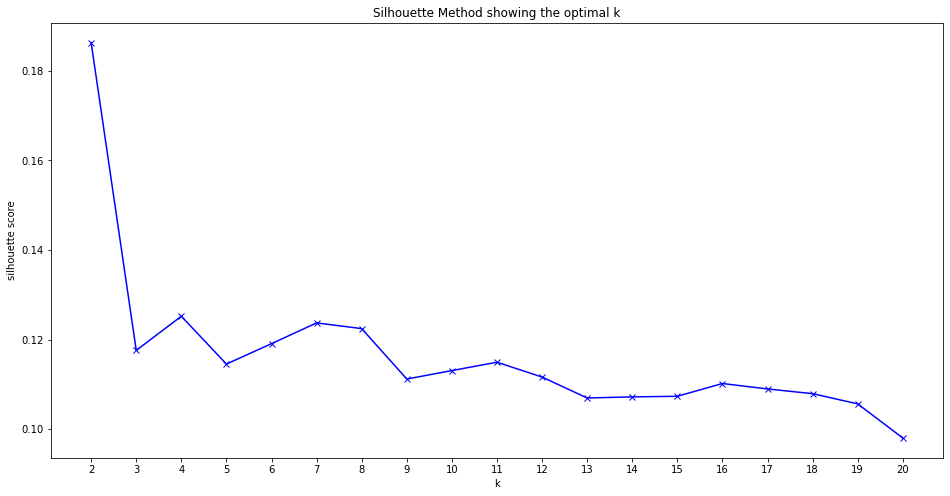

In [60]:

plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

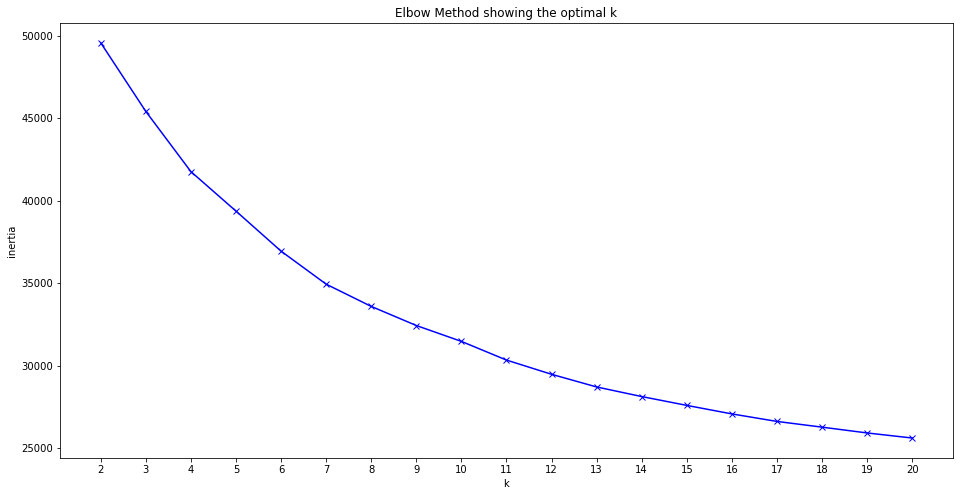

In [61]:
plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

## Objective 2

Save the freshly trained standard scaler with pickle

In [62]:
with open("../datasets/scaler.pickle", "wb") as f:
    pickle.dump(scaler,f)

with open("../datasets/kmeans_4.pickle", "wb") as f:
    pickle.dump(kmeans,f)

In [63]:
def load(filepath = "../data/kmeans.pickle"): 
    try: 
        with open(filename, "rb") as f: 
            return pickle.load(f) 
    except FileNotFoundError: 
        print("File not found!")

In [64]:
scaler2 = load("../datasets/scaler.pickle")
scaler2

KMeans(n_clusters=20, random_state=1234)

Apply the trained scaler to transform the user’s song audio features

In [65]:
song_features = user_song_audio_featuers("Garden")
#x = get_audio_feature_items_into_seperate_lists(song_features)

#.drop(["type", "id", "uri", "track_href", "analysis_url", "time_signature"], axis=1, inplace=True)
#= song_features.drop(numerical.drop(["type", "id", "uri", "track_href", "analysis_url", "time_signature"], axis=1, inplace=True))

In [66]:
song_name = input("Please input the song name: ")

In [69]:
song_dict = {"Song_Name": [song_name], "Artist_Name": [get_artists_name_from_song(song_name)]}
song_df = pd.DataFrame(song_dict)
#song_df.columns
#scaler = StandardScaler()
kmeans = load("../Users/kubra/Desktop/Week3/Project-Week3-Spotify-ML/datasets/datasets/kmeans_4.pickle")
song_features_dict = { key: [value] for key, value in song_features[0][0].items() }
song_features_df = pd.DataFrame(song_features_dict)
#song_features_df
song_df = pd.concat([song_df,song_features_df], axis= 1)
#song_df.columns 
song_numerical = song_df[numerical3.columns]
song_scaled_numpy = scaler.transform(song_numerical)
song_scaled_df = pd.DataFrame(song_scaled_numpy, columns=numerical3.columns)
user_cluster = kmeans.predict(song_scaled_df)[0]
clusters = kmeans.predict(numerical_scaled3)
# top100
# spotify
# clusters 

data2['Cluster'] = clusters[0:data2.shape[0]]
data['Cluster']  = clusters[data2.shape[0]:]
#print(user_cluster)
#Search user song in hot100 dataframe which has the name data2. The search is base in song id
if ( song_df['id'].values in data2['id'].values ): # The song is in the hot100
    recomendation = data2[ data2['Cluster'] == user_cluster ].sample()
    print("Maybe you will also like the song {} from artist {}".format(recomendation['Song_Names'].values[0],recomendation['Artist_Names'].values[0]))
else:
    recomendation = data[ data['Cluster'] == user_cluster ].sample()
    print("Try this one. Maybe you will like the song {} from artist {}".format(recomendation['Song_Names'].values[0],recomendation['Artist_Names'].values[0]))

  

#song_scaled = scaler.transform(song_features)
#song_cluster = kmeans.predict(song_scaled)
#song_final_df = song_df
#song_final_df["Cluster"] = song_cluster

NameError: name 'get_artists_name_from_song' is not defined